### Pre-process the Data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2
import random

In [2]:
def random_brightness(img, factor):
    # assume input is color image
    # convert Red, Green, Blue to Hue, Saturation, Value
    # factor describes the range of brightness scaling: (1 - factor, 1 + factor)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    bright_factor = random.uniform(1. - factor, 1. + factor)
    #print("brightness", bright_factor)
    img_hsv = np.array(img_hsv, np.float)
    img_hsv[:,:,2] = np.minimum(255, img_hsv[:,:,2] * bright_factor)
    img_hsv = np.array(img_hsv, dtype = np.uint8)
    img_new = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    
    return img_new

In [3]:
def xy_translation(img, steer, dfactor):
    # assume input is color image
    # dfactor is the fraction of total pixels as translation range
    nrow, ncol, nch = img.shape
    tX = dfactor * ncol * random.uniform(-1., 1.)
    tY = dfactor * 0.2 * nrow * random.uniform(-1., 1.) # give vertical translation less freedom
    #print("right shift =", tX)
    #print("down shift =", tY)
    Mtrans = np.float32([[1,0,tX], [0,1,tY]])
    img_new = cv2.warpAffine(img, Mtrans,(ncol, nrow))
    steer_new = steer + tX * .004
    #print("steer old/new", steer, steer_new)
    return img_new, steer_new

In [4]:
def crop_resize(img, new_row, new_col):
    nrow, ncol, nch = img.shape
    # crop out img[y1:y2, x1:x2]
    # y1 = 0.3 * nrow: leave out the top 0.3 of image
    # y2 = nrow - 25: leave out the bottom 25 rows
    img_new = img[int(nrow * 0.25) : nrow - 25, 0 : ncol]
    img_new = cv2.resize(img_new,(new_col,new_row), interpolation=cv2.INTER_AREA)
    return img_new

In [5]:
data_dir = "./data/"
driving_log = pd.read_csv(data_dir + "driving_log.csv")

In [6]:
driving_log.head(3)

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011


In [7]:
driving_log.tail(3)

,center,left,right,steering,throttle,brake,speed
8033,IMG/center_2016_12_01_13_46_38_846.jpg,IMG/left_2016_12_01_13_46_38_846.jpg,IMG/right_2016_12_01_13_46_38_846.jpg,0.0,0.0,0.0,1.388364
8034,IMG/center_2016_12_01_13_46_38_922.jpg,IMG/left_2016_12_01_13_46_38_922.jpg,IMG/right_2016_12_01_13_46_38_922.jpg,0.0,0.0,0.0,1.377208
8035,IMG/center_2016_12_01_13_46_38_947.jpg,IMG/left_2016_12_01_13_46_38_947.jpg,IMG/right_2016_12_01_13_46_38_947.jpg,0.0,0.0,0.0,1.374433


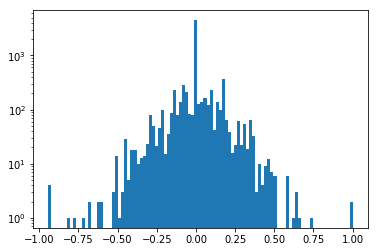

In [8]:
plt.hist(driving_log.steering, log = True, bins = 100);

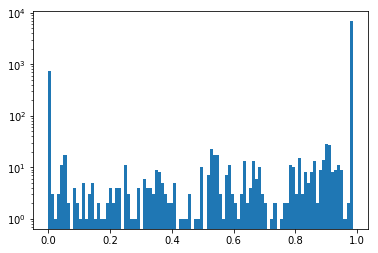

In [9]:
plt.hist(driving_log.throttle, log = True, bins = 100);

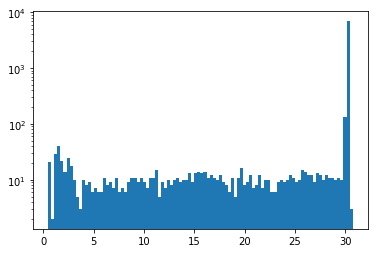

In [10]:
plt.hist(driving_log.speed, log = True, bins = 100);

In [11]:
driving_log = driving_log[driving_log.speed > 1.]

In [12]:
n_entries, n_feats = driving_log.shape

In [18]:
steer_correction = {'left': 0.2, 'center' : 0., 'right' : -0.2}

In [16]:
new_row = 66
new_col = 200

In [17]:
def preprocess_train(entry):
    icamera = np.random.randint(3)
    cam_pos = list(steer_correct.keys())[icamera]
    filename = entry[cam_pos].strip()
    steering = float(entry['steering']) + float(steer_correction[cam_pos])
    img = cv2.imread(data_dir + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    br_img = random_brightness(img, 0.25)
    cr_img = crop_resize(br_img, new_row, new_col)
    steer_new = steering
    #tr_img, steer_new = xy_translation(br_img, steering, 0.3)
    #cr_img = crop_resize(tr_img, new_row, new_col)
    
    flip_ornot = np.random.randint(2)
    #print('flip', flip_ornot)
    if flip_ornot == 1:
        image = cv2.flip(cr_img, 1)    #1 means flip around y-axis
        steer_new = -steer_new
    else:
        image = cr_img
        
    image = np.array(image)    # convert to numpy arrays for Keras
    
    return image, steer_new

In [19]:
def preprocess_valid(entry):
    filename = entry['center'].strip()
    steering = float(entry['steering'])
    img = cv2.imread(data_dir + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cr_img = crop_resize(img, new_row, new_col)
    image = np.array(cr_img)
    return image, steering

In [20]:
def generate_train_batch(log, batch_size = 128, filter_ratio = 0.5):

    batch_images = np.zeros((batch_size, new_row, new_col, 3), dtype = np.uint8)
    batch_steering = np.zeros(batch_size, dtype = np.uint8)
    
    while 1:
        for i_batch in range(batch_size):
            
            reselect = 1
            while reselect == 1:
                i_entry = np.random.randint(len(log))
                #print(i_entry)
                entry = log.iloc[i_entry, :]
                image, steering = preprocess_train(entry)
                if abs(steering) < .05 and np.random.uniform() < filter_ratio:
                    reselect = 1
                else:
                    reselect = 0
            batch_images[i_batch] = image
            batch_steering[i_batch] = steering
            
        yield batch_images, batch_steering

In [21]:
def generate_valid(log):

    while 1:
        for i_entry in range(len(log)):
            #print(i_entry)
            entry = log.iloc[i_entry, :]
            image, steering = preprocess_valid(entry)
            #print(image.shape, steering)
            image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
            steering = np.array([[steering]])
            yield image, steering

In [ ]:
#valid_generator = generate_valid(driving_log)
#train_generator = generate_train_batch(driving_log, batch_size = 3)

In [ ]:
#batch_imgs, batch_strs = next(train_generator)

In [ ]:
# fig = plt.figure(figsize = (16, 12))
# for i in range(1):
#    img, steer = next(train_generator)
#    for j in range(3):
#        ax = fig.add_subplot(3, 2, i*3 + j + 1)
#        print('plot shape', img[j,...].shape)
#        ax.imshow(img[j,...].squeeze())
#        #ax.imshow(img[j,...])
#        ax.set_title(str(np.round(steer[j],4)));

In [ ]:
# fig = plt.figure(figsize = (16, 12))
# for i in range(6):
#     #next(valid_generator)
#     img, steer = next(valid_generator)
#     ax = fig.add_subplot(3, 2, i + 1)
#     print(img.shape)
#     ax.imshow(img[0,...])
        
#     ax.set_title(str(np.round(steer,4)));

In [ ]:
# fig = plt.figure(figsize = (16, 12))
# for i in range(5092,5098):
#     #for p in ['left', 'center', 'right']:
#     image, steering = preprocess_train(driving_log.iloc[i,:])
#     print(image.shape)
#     ax = fig.add_subplot(3, 2, i - 5091)
#     ax.imshow(image)
#     #ax.set_title('steer =' + str(np.round(steering, 4)))
#     ax.set_title(str(i) + '_steer =' + str(np.round(steering, 4)))    

In [22]:
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [23]:
def build_model(drop_prob = 0.1):
    model = Sequential()
    model.add(Lambda(lambda x : x/255. - 0.5, input_shape = (new_row, new_col, 3)))
    # 3 @ 1x1 filter to choose color space automatically
    model.add(Convolution2D(3, 1, 1, init = 'he_normal', activation = 'elu', border_mode = 'valid', name = 'conv0'))
    model.add(Convolution2D(24, 5, 5, init = 'he_normal', subsample = (2, 2), border_mode = 'valid', activation = 'elu', name = 'conv1'))
    model.add(Dropout(drop_prob))
    model.add(Convolution2D(36, 5, 5, init = 'he_normal', subsample = (2, 2), border_mode = 'valid', activation = 'elu', name = 'conv2'))
    model.add(Dropout(drop_prob))
    model.add(Convolution2D(48, 5, 5, init = 'he_normal', subsample = (2, 2), border_mode = 'valid', activation = 'elu', name = 'conv3'))
    model.add(Dropout(drop_prob))
    model.add(Convolution2D(64, 3, 3, init = 'he_normal', subsample = (1, 1), border_mode = 'valid', activation = 'elu', name = 'conv4'))
    model.add(Dropout(drop_prob))
    model.add(Convolution2D(64, 3, 3, init = 'he_normal', subsample = (1, 1), border_mode = 'valid', activation = 'elu', name = 'conv5'))
    model.add(Flatten())
    model.add(Dense(100, init = 'he_normal', activation = 'elu', name = 'full1'))
    model.add(Dropout(drop_prob))
    model.add(Dense(50, init = 'he_normal', activation = 'elu', name = 'full2'))
    model.add(Dropout(drop_prob))
    model.add(Dense(10, init = 'he_normal', activation = 'elu', name = 'full3'))
    model.add(Dropout(drop_prob))
    model.add(Dense(1, init = 'he_normal', name = 'full4'))
    return model

In [24]:
train_cont = False
if train_cont:
    model = load_model('model.h5')
else:
    model = build_model(0.5)
    
adam = Adam(lr=1e-4)
model.compile(loss = 'mse', optimizer = adam)

In [25]:
val_loss_min = 1E04
train_generator = generate_train_batch(driving_log, batch_size = 64, filter_ratio = 0.9)
valid_generator = generate_valid(driving_log)

history = model.fit_generator(train_generator,
            samples_per_epoch=256, nb_epoch=5,validation_data=valid_generator,
                        nb_val_samples=n_entries, verbose = 1)

val_loss = history.history['val_loss'][0]
if val_loss < val_loss_min:
    val_loss_min = val_loss
    model.save('model.h5')

Epoch 1/5
256/256 [==============================] - 92s - loss: 14.2871 - val_loss: 0.1601
Epoch 2/5
192/256 [=====================>........] - ETA: 1s - loss: 10.6965

KeyboardInterrupt: 

In [ ]:
history.params

In [ ]:
history.history.keys()